In [3]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort
from albumentations.pytorch import ToTensorV2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")

In [4]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/answer.csv", header=None)
df.columns = ['file','target']
print("Target ### Total:  {}".format(len(df)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
Target ### Total:  1242


In [5]:
df_train = pd.DataFrame()
df_train['image_path'] = images_train
df_train['target'] = df['target']
df_train['dataset']  = 'solafune'

In [6]:
df_train.head()

,image_path,target,dataset
0,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
1,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
2,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
3,/home/sebastien/Documents/projects/solafune-fi...,1,solafune
4,/home/sebastien/Documents/projects/solafune-fi...,0,solafune


In [8]:
from loguru import logger


# Updated geometric_transform with random horizontal and vertical flips
geometric_transform = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip()
])

In [17]:
def data_augmentation(image):
    

    apply_transform = ["yes", "no"]
    
    if random.choice(apply_transform)=="yes":
        logger.info("Augmentation")
        
    
            
        logger.info("geometric_transform ")
        aug_image = geometric_transform(image=image)
        
    
    else:
        logger.info("No Augmentation")
    
        aug_image = image
        
    return aug_image
    

In [51]:
data = rxr.open_rasterio(df_train['image_path'].iloc[-1], masked=False)

In [52]:
aug_image = data_augmentation(image=data.values)
aug_image['image']

2023-12-31 15:09:34.174 | INFO     | __main__:data_augmentation:7 - Augmentation
2023-12-31 15:09:34.175 | INFO     | __main__:data_augmentation:11 - geometric_transform 


array([[[0.02725, 0.02725, 0.0279 , ..., 0.0282 , 0.0282 , 0.0281 ],
        [0.02725, 0.02725, 0.02725, ..., 0.0302 , 0.0302 , 0.0302 ],
        [0.02725, 0.02725, 0.02725, ..., 0.0299 , 0.0302 , 0.0299 ],
        ...,
        [0.05395, 0.05395, 0.0581 , ..., 0.0454 , 0.0454 , 0.0454 ],
        [0.05535, 0.0456 , 0.06415, ..., 0.047  , 0.047  , 0.047  ],
        [0.0465 , 0.05535, 0.0622 , ..., 0.0454 , 0.047  , 0.0454 ]],

       [[0.0303 , 0.0298 , 0.0283 , ..., 0.0348 , 0.0318 , 0.0316 ],
        [0.02855, 0.0301 , 0.0285 , ..., 0.0386 , 0.0596 , 0.0658 ],
        [0.02545, 0.02725, 0.0292 , ..., 0.03095, 0.0544 , 0.0751 ],
        ...,
        [0.04345, 0.04345, 0.045  , ..., 0.0427 , 0.0408 , 0.0425 ],
        [0.0535 , 0.0454 , 0.0545 , ..., 0.04615, 0.04305, 0.0438 ],
        [0.0505 , 0.05105, 0.0443 , ..., 0.0462 , 0.0417 , 0.0428 ]],

       [[0.05885, 0.0599 , 0.0538 , ..., 0.0582 , 0.0568 , 0.0604 ],
        [0.058  , 0.0589 , 0.05435, ..., 0.0623 , 0.0871 , 0.0928 ],
    

In [77]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values

    image = data_augmentation(image=image)

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return rgb_composite_n


def visualization(image):
    
   

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    # print("image path {}".format(image_path))
    # print("image {}".format(rgb_composite_n.shape))

    
    
    # Create a figure with subplots to display the images
    plt.figure(figsize=(15, 5))
    
    # Display the images
    plt.imshow(rgb_composite_n)
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [92]:
image = rxr.open_rasterio(df_train['image_path'].iloc[-1], masked=False)

# Define your augmentation transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Random horizontal flip with a probability of 0.5
    A.VerticalFlip(p=0.5),    # Random vertical flip with a probability of 0.5
    # Add more augmentations as needed
])

# Convert the xarray image to a NumPy array
image_np = image.transpose('y', 'x', 'band')  # Transpose the image if needed

# Perform augmentation on the image
augmented = transform(image=image_np.values)

# Retrieve the augmented image
augmented_image = augmented['image']
augmented_image = np.transpose(augmented_image, (2,1,0))

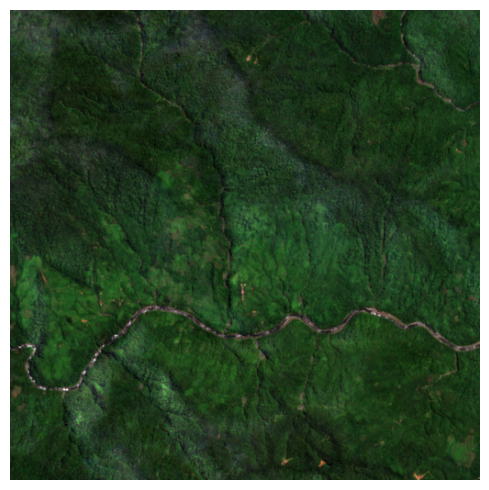

In [93]:
visualization(image.values)

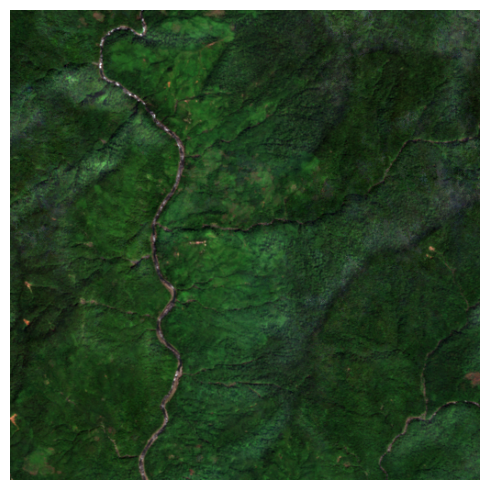

In [94]:
visualization(augmented_image)

In [112]:
def data_augmentation(image):
    

    apply_transform = ["yes", "no"]
    
    if random.choice(apply_transform)=="yes":
        logger.info("Augmentation")
        
    
            
        logger.info("geometric_transform ")
        # Define your augmentation transformations
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),  # Random horizontal flip with a probability of 0.5
            A.VerticalFlip(p=0.5),    # Random vertical flip with a probability of 0.5
            # Add more augmentations as needed
        ])
        
        # Convert the xarray image to a NumPy array
        image_np = image.transpose('y', 'x', 'band')  # Transpose the image if needed
        
        # Perform augmentation on the image
        augmented = transform(image=image_np.values)
        
        # Retrieve the augmented image
        augmented_image = augmented['image']
        augmented_image = np.transpose(augmented_image, (2,1,0))
        
    
    else:
        logger.info("No Augmentation")
    
        augmented_image = image.values
        
    return augmented_image

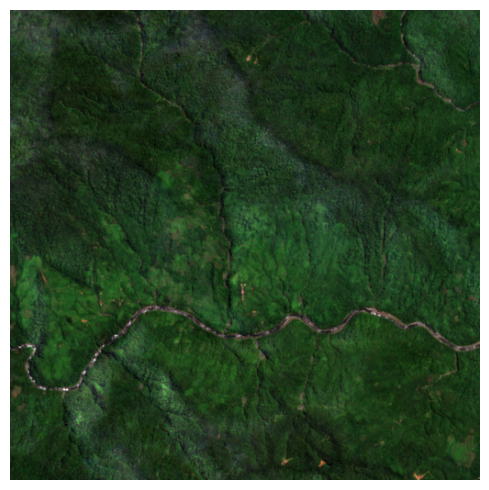

In [113]:
visualization(image.values)

2023-12-31 15:42:06.265 | INFO     | __main__:data_augmentation:7 - Augmentation
2023-12-31 15:42:06.274 | INFO     | __main__:data_augmentation:11 - geometric_transform 


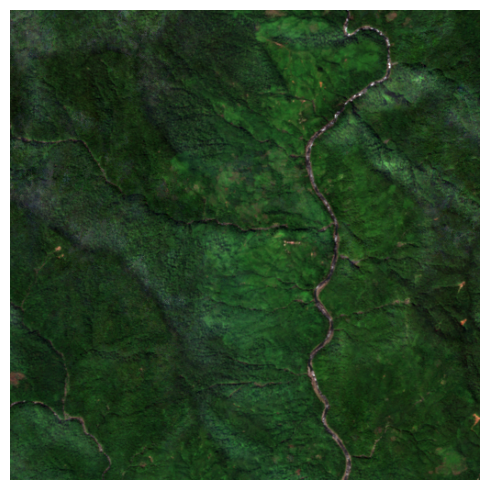

In [118]:
augmented_image = data_augmentation(image)
visualization(augmented_image)

In [117]:
import torch
test = torch.Tensor(augmented_image)